The avocado dataset contains time-stamped market recordsfor many U.S. geographies like Los Angeles and San Diego, some states, broader regions like, West, Northeast, and Total U.S. For each date and place, it reports the average retail price per avocado, the total number of avocados sold, and detailed breakouts by size using PLU codes, 4046 (small), 4225 (large), and 4770 (extra-large), as well as bag counts. Each record also tracks whether it was conventional or organic avocados.


In [130]:
import numpy as np
import pandas as pd
from plotnine import *

In [131]:
avocadodata = pd.read_csv('avocado-updated-2020.csv')

In [132]:
avocadodata.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


In [133]:
avocadodata = avocadodata.rename(columns={
    '4046': 'small',
    '4225': 'large',
    '4770': 'extra_large'
})


In [134]:
avocadodata["geography"].unique()

array(['Albany', 'Atlanta', 'Baltimore/Washington', 'Boise', 'Boston',
       'Buffalo/Rochester', 'California', 'Charlotte', 'Chicago',
       'Cincinnati/Dayton', 'Columbus', 'Dallas/Ft. Worth', 'Denver',
       'Detroit', 'Grand Rapids', 'Great Lakes', 'Harrisburg/Scranton',
       'Hartford/Springfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'Las Vegas', 'Los Angeles', 'Louisville', 'Miami/Ft. Lauderdale',
       'Midsouth', 'Nashville', 'New Orleans/Mobile', 'New York',
       'Northeast', 'Northern New England', 'Orlando', 'Philadelphia',
       'Phoenix/Tucson', 'Pittsburgh', 'Plains', 'Portland',
       'Raleigh/Greensboro', 'Richmond/Norfolk', 'Roanoke', 'Sacramento',
       'San Diego', 'San Francisco', 'Seattle', 'South Carolina',
       'South Central', 'Southeast', 'Spokane', 'St. Louis', 'Syracuse',
       'Tampa', 'Total U.S.', 'West', 'West Tex/New Mexico'], dtype=object)

In [135]:
national_labels = {"Total U.S."}
us_regions = {
    "West", "Northeast",
    "Great Lakes", "Midsouth", "Plains",
    "Southeast", "South Central",
    "West Tex/New Mexico", "Northern New England"
}
us_states = {
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut",
    "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
    "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan",
    "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada",
    "New Hampshire", "New Jersey", "New Mexico", "North Carolina",
    "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island",
    "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont",
    "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming", "District of Columbia"
}
def classify_geo(g):
    if g in national_labels:
        return "National"
    elif g in us_regions:
        return "Region"
    elif g in us_states:
        return "State"
    else:
        return "Metro"

In [136]:
avocadodata["geo_type"] = avocadodata["geography"].apply(classify_geo)

In [137]:
avocado_clean = avocadodata

In [138]:
region_sales_2017 = (
    avocado_clean[
        (avocado_clean["year"] == 2017) &
        (avocado_clean["type"].str.lower() == "organic") &
        (avocado_clean["geography"].isin(us_regions))
    ]
    .groupby("geography", as_index=False)["small"]
    .sum()
    .sort_values("small", ascending=False)
)

In [139]:
print (region_sales_2017)

              geography       small
7                  West  1870206.29
5         South Central  1717104.19
2             Northeast   925832.36
6             Southeast   285124.34
0           Great Lakes   202487.68
1              Midsouth   186395.50
4                Plains   168583.40
8   West Tex/New Mexico   110910.95
3  Northern New England     1249.48


In [140]:
avocado_clean["date"] = pd.to_datetime(avocado_clean["date"])
avocado_clean["year"] = avocado_clean["date"].dt.year
avocado_clean["month"] = avocado_clean["date"].dt.month_name()
avocado_clean["day"] = avocado_clean["date"].dt.day

In [141]:
monthly_avg_volume = (
    avocado_clean.groupby("month", as_index=False)["total_volume"]
    .mean()
    .sort_values("total_volume", ascending=False)
)
top_month = monthly_avg_volume.iloc[0]["month"]

In [142]:
print (top_month)

May


In [143]:
metro = avocado_clean[avocado_clean["geo_type"] == "Metro"]
top5_metros = (
    metro.groupby("geography", as_index=False)["total_volume"]
    .mean()
    .sort_values("total_volume", ascending=False)
    .head(5)
)

print(top5_metros)

           geography  total_volume
20       Los Angeles  1.567566e+06
25          New York  8.631458e+05
10  Dallas/Ft. Worth  7.127519e+05
16           Houston  6.876533e+05
28    Phoenix/Tucson  6.250383e+05


In [144]:
top5_names = top5_metros["geography"].tolist()

top5_df = metro[metro["geography"].isin(top5_names)]


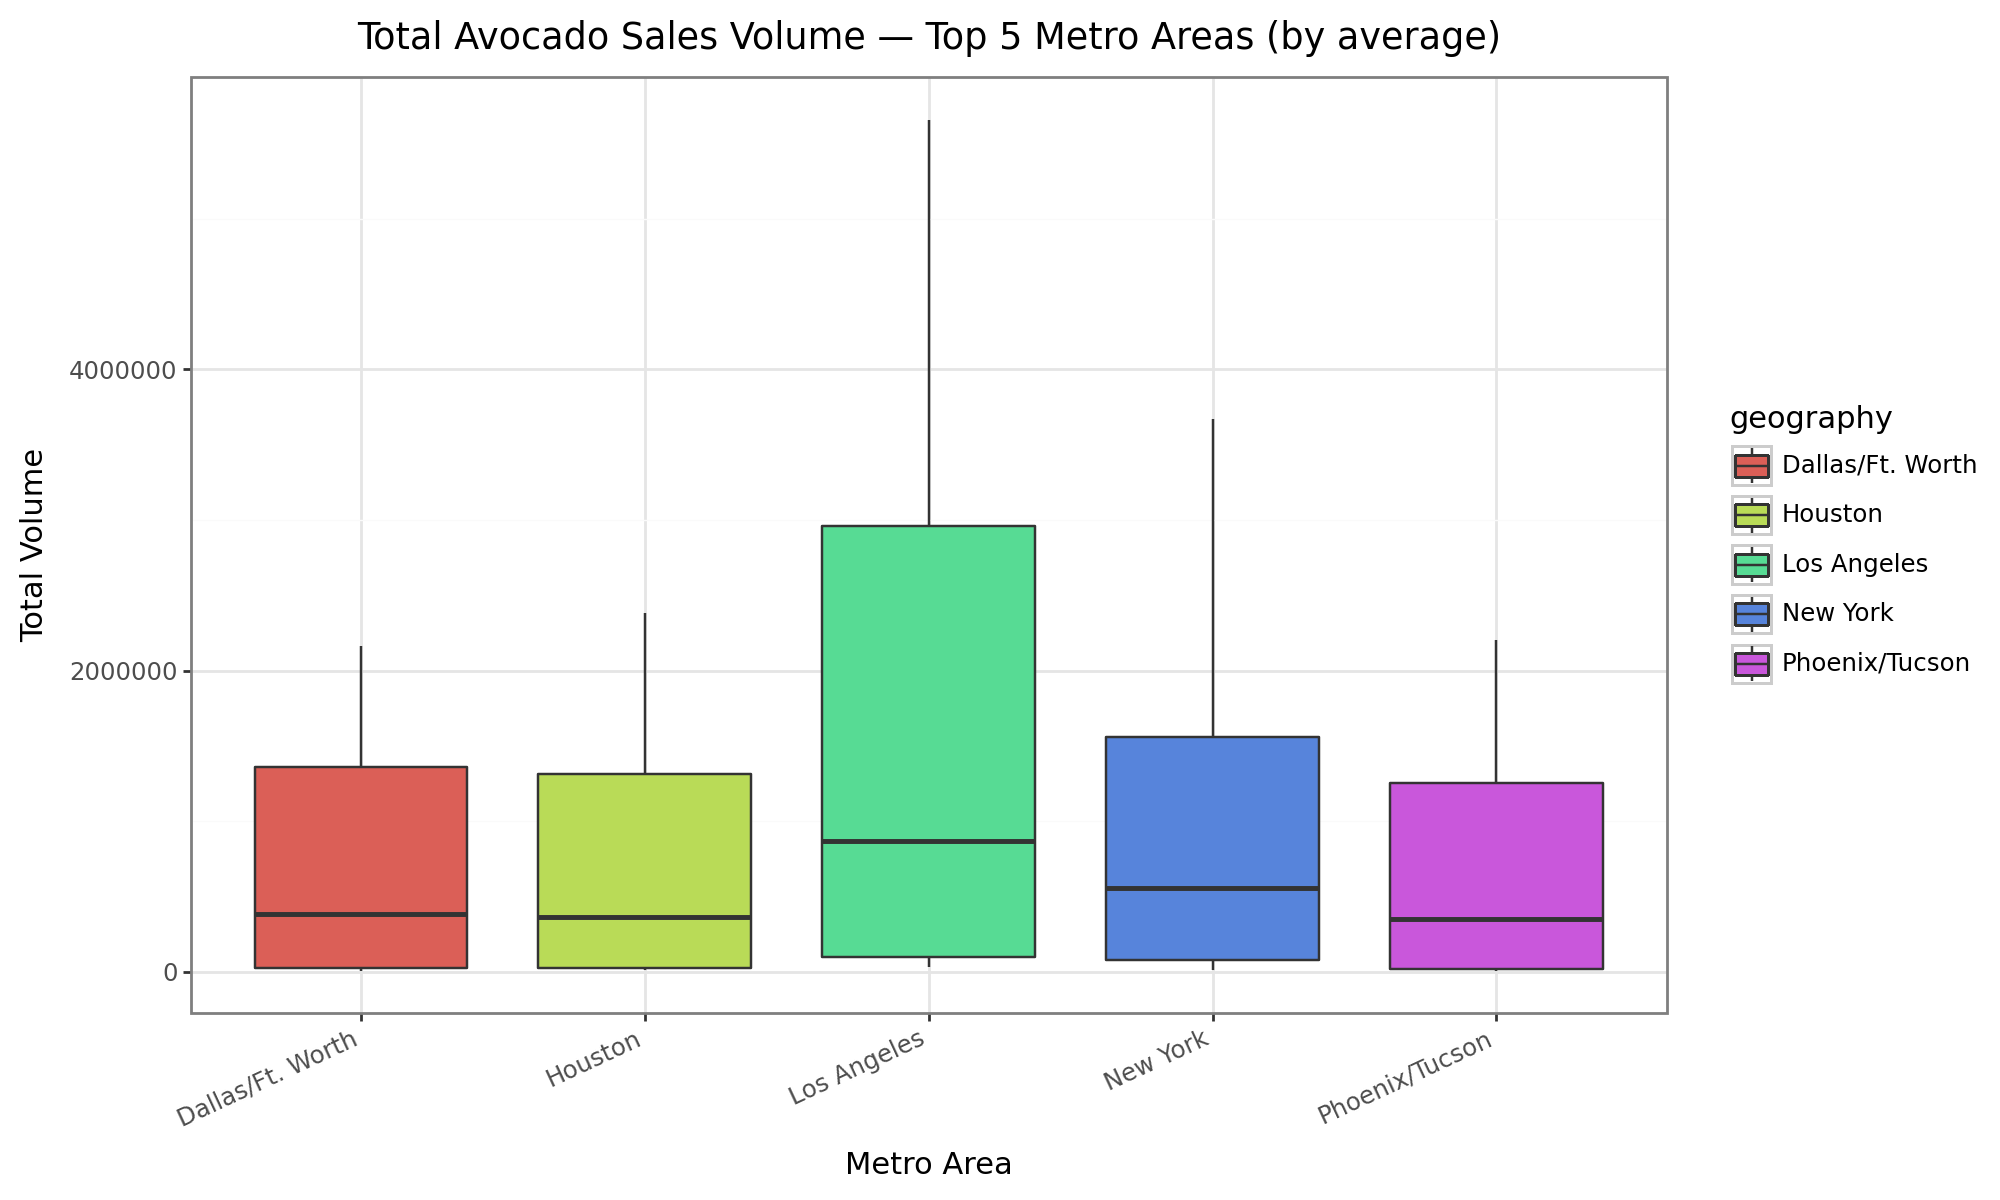

In [145]:
plot = (
    ggplot(top5_df, aes(x='geography', y='total_volume', fill='geography'))
    + geom_boxplot()
    + theme_bw()
    + labs(
        title='Total Avocado Sales Volume — Top 5 Metro Areas (by average)',
        x='Metro Area',
        y='Total Volume'
    )
    + theme(
        axis_text_x=element_text(rotation=25, ha='right'),
        figure_size=(10, 6)
    )
)

plot

In [158]:
ca_metros = ["Los Angeles", "San Diego", "Sacramento", "San Francisco"]
avocado_ca = (
    avocado_clean[avocado_clean["geography"].isin(ca_metros)]
    .copy()
)
avocado_ca["month"] = pd.to_datetime(avocado_ca["date"]).dt.to_period("M").dt.to_timestamp() #this last code GEMINI added when I was doing my OUTSIDE Data response.

In [147]:
summary_price = (
    avocado_ca
    .groupby(["geography", "type"])["average_price"]
    .agg(mean_price="mean", median_price="median", sd="std", n="count")
    .reset_index()
)

In [148]:
summary_price

,geography,type,mean_price,median_price,sd,n
0,Los Angeles,conventional,1.047124,1.020,0.231167,306
1,Los Angeles,organic,1.574902,1.585,0.311722,306
2,Sacramento,conventional,1.295359,1.260,0.219177,306
3,Sacramento,organic,1.873856,1.840,0.292875,306
4,San Diego,conventional,1.113856,1.090,0.242960,306
5,San Diego,organic,1.798366,1.800,0.331655,306
6,San Francisco,conventional,1.400490,1.390,0.272060,306
7,San Francisco,organic,2.119444,2.060,0.395854,306


In [149]:
sp = summary_price.assign(type=summary_price["type"].str.lower())
wide = sp.pivot(index="geography", columns="type", values="mean_price")
wide["diff_conv_minus_org"] = wide["conventional"] - wide["organic"]
wide["abs_diff"] = wide["diff_conv_minus_org"].abs()
wide_sorted = wide.sort_values("abs_diff", ascending=False)
biggest_geo = wide_sorted.index[0]
biggest_geo

'San Francisco'

/tmp/ipython-input-693472476.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


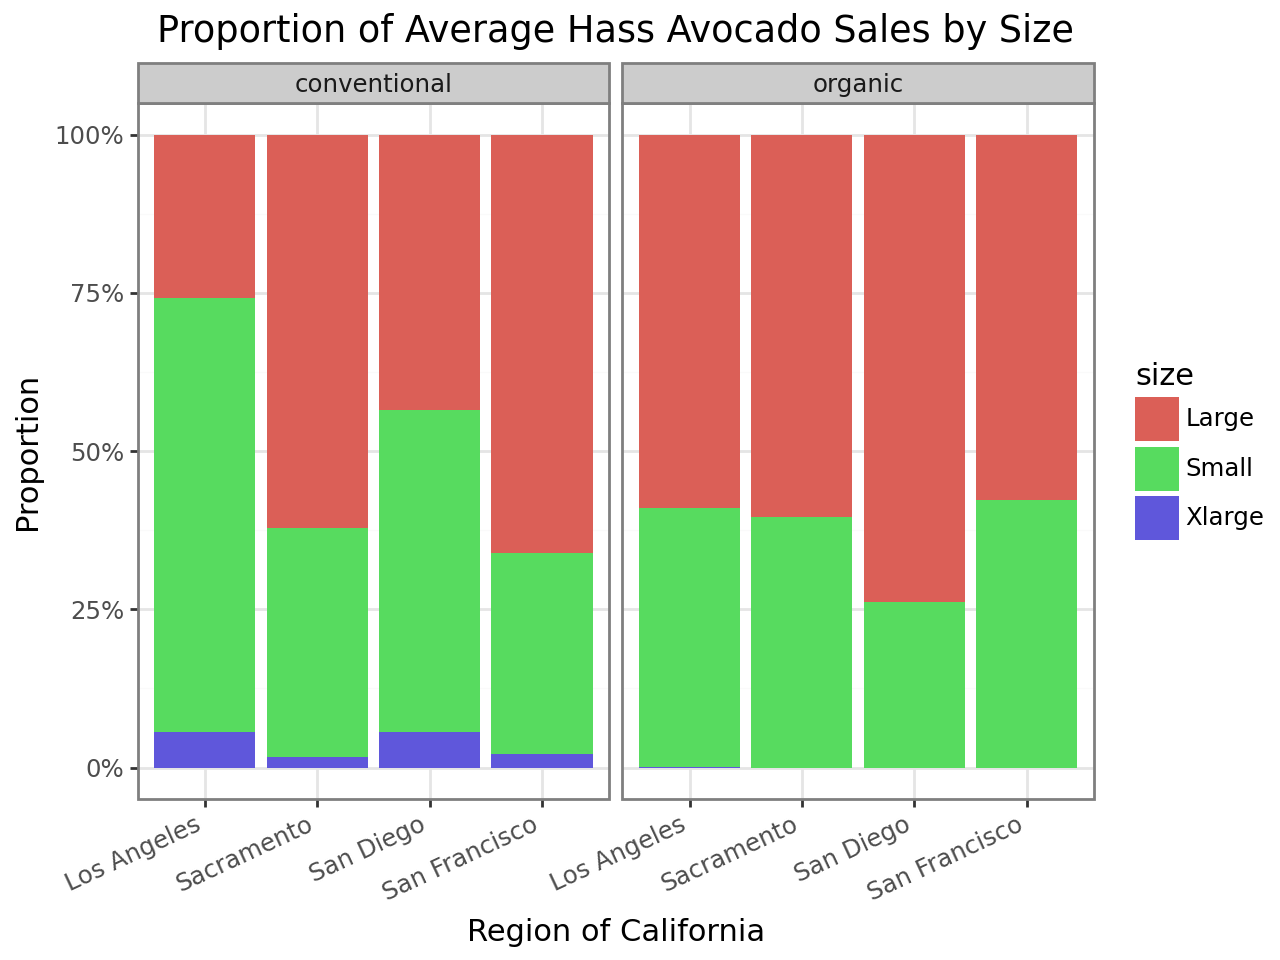

In [150]:
avocado_ca["type"] = avocado_ca["type"].str.strip().str.lower()
avocado_ca["type"] = pd.Categorical(avocado_ca["type"], categories=["conventional", "organic"], ordered=True)

if {"small","large","extra_large"}.issubset(avocado_ca.columns):
    size_map = {"small":"Small", "large":"Large", "extra_large":"Xlarge"}
    size_cols = ["small","large","extra_large"]
elif {"4046","4225","4770"}.issubset(avocado_ca.columns):
    size_map = {"4046":"Small", "4225":"Large", "4770":"Xlarge"}
    size_cols = ["4046","4225","4770"]

long = (
    avocado_ca.melt(id_vars=["geography","type"], value_vars=size_cols,
            var_name="size", value_name="volume")
      .assign(size=lambda d: d["size"].map(size_map))
)

avg_long = (
    long.groupby(["geography","type","size"], as_index=False)["volume"]
        .mean()
)

p = (
    ggplot(avg_long, aes(x="geography", y="volume", fill="size"))
    + geom_bar(stat="identity", position="fill")
    + facet_grid("~type")
    + theme_bw()
    + labs(
        title="Proportion of Average Hass Avocado Sales by Size",
        x="Region of California",
        y="Proportion",
        fill="size"
    )
    + scale_y_continuous(labels=lambda l: [f"{int(v*100)}%" for v in l])
    + theme(axis_text_x=element_text(rotation=25, ha="right"))
) #I used chat gpt to help me get the sizing right which is how i got lambda and it gave me the fucntion for scale_y_continous which I then had it explain to me what that means


p

**USING OUTSIDE DATA**
I downloaded median sale price data from Redfin from January 2015 - Decemeber 2020 in the four metro regions of California to match up with our avacado data.

/tmp/ipython-input-3191671446.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


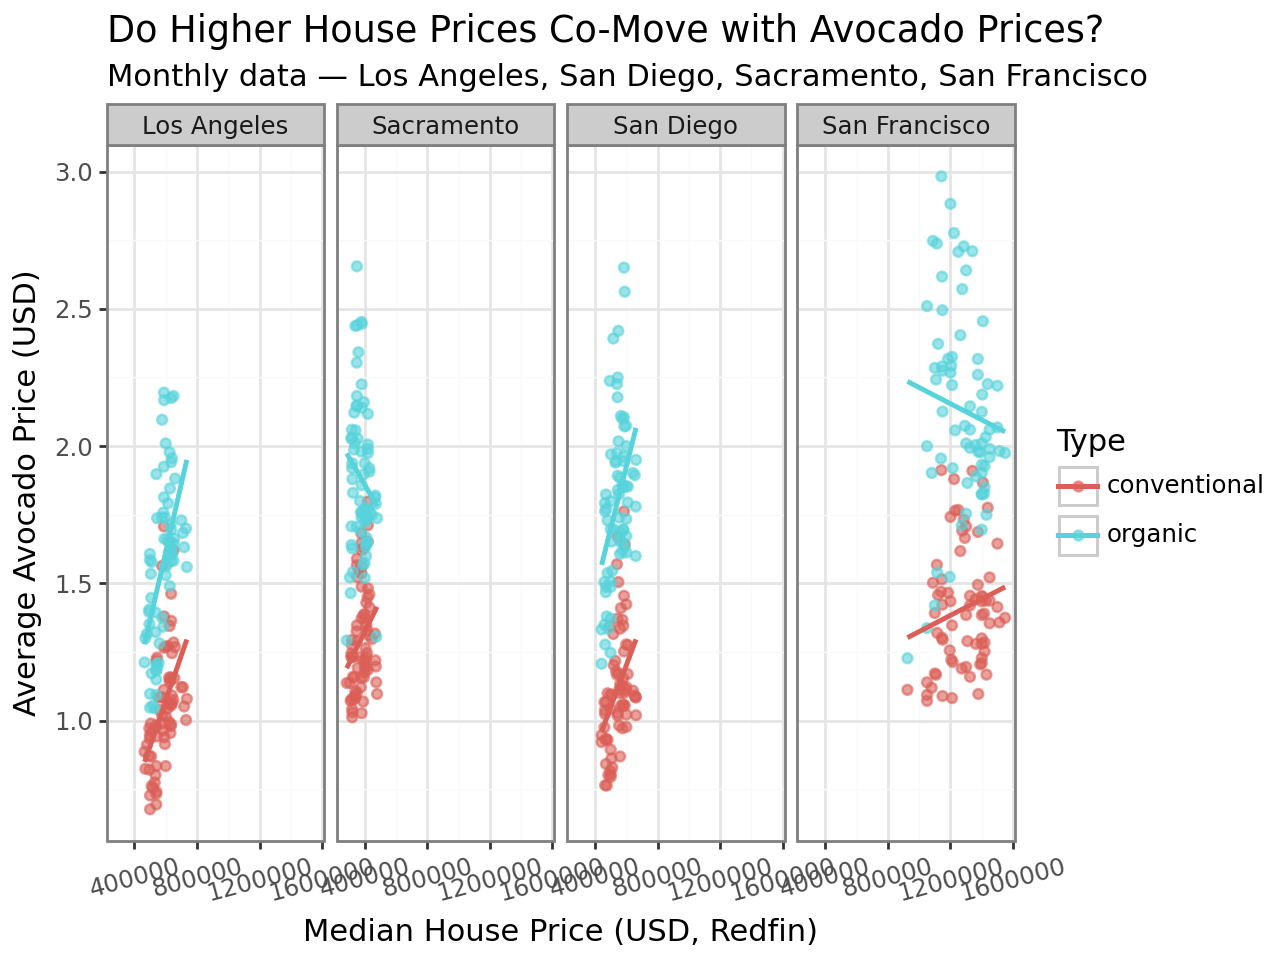

In [165]:
av_m = (avocado_ca.groupby(["geography","type","month"], as_index=False)
          .agg(avg_avocado_price=("average_price", "mean"),
               total_volume=("total_volume", "sum")))

rf = pd.read_csv("med_sale_price (1).csv",encoding="utf-16", sep=None, engine="python")

rf.columns = rf.iloc[0]
rf = rf.iloc[1:].rename(columns={rf.columns[0]: "Region"})

value_cols = [c for c in rf.columns if c != "Region"]
rf_long = rf.melt(id_vars="Region", value_vars=value_cols,
                  var_name="month_label", value_name="price_str")

rf_long["geography"] = rf_long["Region"].str.replace(", CA metro area", "", regex=False)

# Ensure the month column in rf_long is also datetime64[ns]
rf_long["month"] = pd.to_datetime(rf_long["month_label"])

# convert "$735K" style to number
def parse_price(s):
    if pd.isna(s): return np.nan
    s = str(s).replace("$","").replace(",","").strip()
    if s.endswith(("K","k")):
        return float(s[:-1]) * 1000
    return float(s) if s else np.nan

rf_long["median_house_price"] = rf_long["price_str"].apply(parse_price)

# monthly median by metro
# Ensure the month column in houses_m is also datetime64[ns]
houses_m = (rf_long.groupby(["geography","month"], as_index=False)
                    .agg(median_house_price=("median_house_price","mean")))

# JOINING THE DATA
join_df = av_m.merge(houses_m, on=["geography","month"], how="inner")
p = (
    ggplot(join_df, aes(x="median_house_price", y="avg_avocado_price", color="type"))
    + geom_point(alpha=0.6)
    + geom_smooth(method="lm", se=False)   # linear fit to show direction
    + facet_wrap("~geography", nrow=1)
    + theme_bw()
    + labs(
        title="Do Higher House Prices Co-Move with Avocado Prices?",
        subtitle="Monthly data — Los Angeles, San Diego, Sacramento, San Francisco",
        x="Median House Price (USD, Redfin)",
        y="Average Avocado Price (USD)",
        color="Type"
    )
    + theme(axis_text_x=element_text(rotation=15))
)
p

In [161]:
#Chat helped me create these correlation matrix which helps show the relationship between housing prices and avocado prices. I wasn't sure how to do this without using CHATGPT.
def summarize_corr(df, col):
    s = df[col].dropna().abs()
    if s.empty:
        return np.nan, "insufficient data"
    med = s.median()
    if med < 0.2:  label = "little to no linear relationship"
    elif med < 0.4: label = "a weak relationship"
    elif med < 0.6: label = "a moderate relationship"
    else:           label = "a strong relationship"
    return med, label

med_abs_price, label_price = summarize_corr(corr_price, "corr_house_vs_avocado_price")
med_abs_vol,   label_vol   = summarize_corr(corr_volume, "corr_house_vs_avocado_volume")

print("\n=== Correlations (house price vs avocado price) by metro × type ===")
print(corr_price.sort_values(["geography","type"]).to_string(index=False))
print("\n=== Correlations (house price vs avocado volume) by metro × type ===")
print(corr_volume.sort_values(["geography","type"]).to_string(index=False))

print("\n=== Argument ===")
print(f"Across the four CA metros, the median absolute correlation between house prices and avocado PRICES is "
      f"{med_abs_price:.2f} — indicating {label_price}.")
print(f"For avocado SALES VOLUME, the median absolute correlation is {med_abs_vol:.2f} — indicating {label_vol}.")
print("Taken together, this joined monthly data provides little evidence that local housing prices materially drive "
      "avocado prices or sales; produce markets are more likely driven by seasonality, supply, and promotions.")


=== Correlations (house price vs avocado price) by metro × type ===
    geography         type  corr_house_vs_avocado_price
  Los Angeles conventional                     0.502301
  Los Angeles      organic                     0.546438
   Sacramento conventional                     0.276556
   Sacramento      organic                    -0.167104
    San Diego conventional                     0.393097
    San Diego      organic                     0.425397
San Francisco conventional                     0.184183
San Francisco      organic                    -0.112213

=== Correlations (house price vs avocado volume) by metro × type ===
    geography         type  corr_house_vs_avocado_volume
  Los Angeles conventional                      0.168550
  Los Angeles      organic                      0.692170
   Sacramento conventional                      0.396389
   Sacramento      organic                      0.636911
    San Diego conventional                      0.278287
    San Diego  